In [1]:
# copied from https://github.com/Newmu/gan_tutorial
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython import display
from tensorflow.examples.tutorials.mnist import input_data

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def grid_vis(imgs):
    """takes a list of images and show them side-by-side in a grid"""
    nh = nw = int(np.ceil(np.sqrt(len(imgs))))
    h, w = imgs[0].shape
    grid = np.zeros((nh*h, nw*w))
    for n, img in enumerate(imgs):
        i, j = n%nh, n//nh
        grid[j*h:(j+1)*h, i*w:(i+1)*w] = img
    return grid

def preprocess(x):
    """
    reshape vectors back to images
    pad with 2 zero pixel border to make shapes nice
    rescale values to 0 mean -1 to 1 range (from usual 0 to 1)
    """
    x = x.reshape(-1, 28, 28)
    x = np.pad(x, [[0, 0], [2, 2], [2, 2]], mode='constant', constant_values=0)
    return x[:, :, :, np.newaxis]*2-1

def dense(x, scope, n_h):
    """
    standard affine layer
    scope = name tf variable scope
    n_h   = number of hidden units
    """
    with tf.variable_scope(scope):
        n_x = x.get_shape().as_list()[-1]
        w = tf.get_variable('w', [n_x, n_h], initializer=tf.random_normal_initializer(stddev=0.04))
        b = tf.get_variable('b', [n_h], initializer=tf.constant_initializer(0))
        return tf.matmul(x, w)+b
    
def conv(x, scope, r_f, n_f, stride=1):
    """
    standard conv layer
    scope  = name tf variable scope
    r_f    = receptive field of kernel
    n_f    = # of kernels
    stride = locations
    """
    with tf.variable_scope(scope):
        n_x = x.get_shape().as_list()[-1]
        w = tf.get_variable('w', [r_f, r_f, n_x, n_f], initializer=tf.random_normal_initializer(stddev=0.04))
        b = tf.get_variable('b', [n_f], initializer=tf.constant_initializer(0))
        return tf.nn.convolution(x, w, padding='SAME', strides=[stride, stride])+b

def upsample(x, ratio=2):
    """
    takes a 4D image tensor and increases spatial resolution by replicating values
    so for ratio=2 a 2x2 image becomes a 4x4 image with each value repeated twice
    ratio = # of spatial repeats
    """
    n_h, n_w = x.get_shape().as_list()[1:3]
    return tf.image.resize_nearest_neighbor(x, [n_h*ratio, n_w*ratio])
    
def generator(Z, reuse=False):
    """
    modified DCGAN (progressive GAN-ized)
    consists of interleaved upsample and convolution operations
    leaky relu used for good gradient flow
    """
    with tf.variable_scope('generator', reuse=reuse):
        h = tf.nn.leaky_relu(dense(Z, 'hz', n_h=256*4*4), 0.2)
        h = tf.reshape(h, [n_batch, 4, 4, 256]) #convert from feature vector to 4D image tensor
        h = upsample(h)
        h = tf.nn.leaky_relu(conv(h, 'h', r_f=5, n_f=128), 0.2)
        h = upsample(h)
        h = tf.nn.leaky_relu(conv(h, 'h2', r_f=5, n_f=64), 0.2)
        h = upsample(h)
        h = tf.nn.leaky_relu(conv(h, 'h3', r_f=5, n_f=32), 0.2)
        x = conv(h, 'hx', r_f=1, n_f=n_c) #linear output - could use sigmoid or tanh but gradient vanishing issues
        return x
    
def discriminator(X, reuse=False):
    """
    DCGAN disriminator without batchnorm for simplicity
    leaky relu used for good gradient flow + smoother function
    keep model shallow and simple with quick downsample via strided convolutions
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        h = tf.nn.leaky_relu(conv(X, 'hx', r_f=5, n_f=32, stride=2), 0.2)
        h = tf.nn.leaky_relu(conv(h, 'h', r_f=5, n_f=64, stride=2), 0.2)
        h = tf.nn.leaky_relu(conv(h, 'h2', r_f=5, n_f=128, stride=2), 0.2)
        h = tf.reshape(h, [n_batch, -1]) #convert from 4D image tensor to feature vector
        logits = dense(h, 'clf', 1)
        return logits
    
def cross_entropy_loss(logits, labels):
    """
    default GAN training loss
    """
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

def noise(n, n_z):
    """
    n random spherical gaussian noise with unit variance
    """
    return np.random.randn(n, n_z).astype(np.float32)

def visualize(z):
    """
    show evolution of samples of the same points in latent space over training
    """
    g_z_sample = sess.run(g_z, {Z:z})
    fig = plt.figure(figsize=(5, 5))
    plt.title('G: %.3f D: %.3f Updates: %d'%(g_cost, d_cost, n_updates))
    plt.imshow(grid_vis(np.clip((g_z_sample.reshape(-1, 32, 32)+1)/2, 0, 1)), cmap='gray')
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [3]:
#setup and hyperparameters
mnist = input_data.read_data_sets('data/mnist/')
n_h, n_w, n_c = [32, 32, 1]
n_z = 128
n_batch = 100
lr = 2.5e-4
n_updates_total = 55000
z_vis = noise(n_batch, n_z)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
#tensorflow inputs
X = tf.placeholder(tf.float32, [None, n_h, n_w, n_c])
Z = tf.placeholder(tf.float32, [None, n_z])

#setup modules
g_z   = generator(Z)
d_g_z = discriminator(g_z)
d_x   = discriminator(X, reuse=True)

#generator tries to get discriminator to classify its samples as real
g_loss     = cross_entropy_loss(logits=d_g_z, labels=tf.ones(tf.shape(d_g_z)))
#discriminator tries to classify generator samples as fake
d_g_z_loss = cross_entropy_loss(logits=d_g_z, labels=tf.zeros(tf.shape(d_g_z)))
#discriminator tries to classify data samples as real
d_x_loss   = cross_entropy_loss(logits=d_x,   labels=tf.ones(tf.shape(d_x)))
#overall discriminator objective is correctly classifying both real and fake data
d_loss     = (d_g_z_loss + d_x_loss)/2

#build training ops
g_vars  = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')
g_train = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5).minimize(g_loss,  var_list=g_vars)
d_vars  = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')
d_train = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5).minimize(d_loss,  var_list=d_vars)

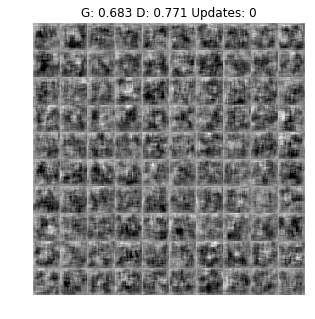

  0%|                                      | 4/55000 [00:19<76:21:08,  5.00s/it]

In [ ]:
#alternate updates of discriminator on minibatches of real data and generator
%matplotlib inline

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for n_updates in tqdm(list(range(n_updates_total)), ncols=80, leave=False):
    xs, _ = mnist.train.next_batch(n_batch)
    d_cost, _ = sess.run([d_loss, d_train], {X:preprocess(xs), Z:noise(n_batch, n_z)})
    g_cost, _ = sess.run([g_loss, g_train], {Z:noise(n_batch, n_z)})
    if n_updates % 100 == 0:
        visualize(z_vis)